In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [3]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


In [4]:
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'disk_simulations'
    )

sphere_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'DrudeSphere80nm_inWater.mat'
    ))
## Convert to eV and plot spectra 
hw = 1240/sphere_spec['enei'][0]
spec = sphere_spec['sca']

# plt.figure(figsize=(2,1.5), dpi=150)
# for i, spectrum in enumerate(spec.T):
#     plt.plot(hw, spectrum)
# plt.xlabel('eV')
# plt.ylabel('$\mathrm{nm}^2$')
# plt.title('Drude Sphere Scattering')

array([1.30752893e+01, 1.03788711e+01, 3.84087654e-02, 4.03368752e+01])

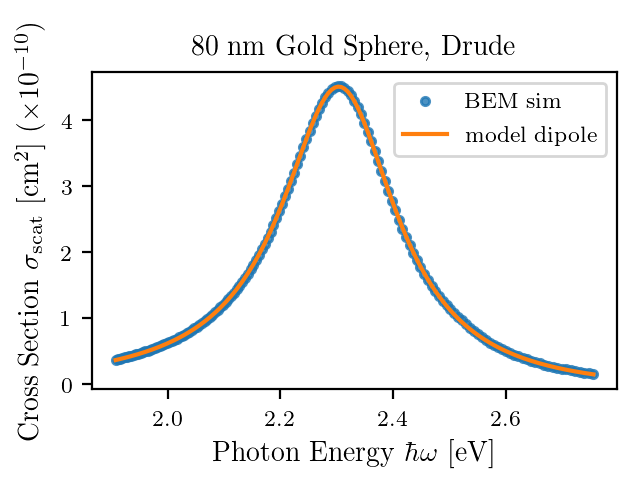

In [5]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

eneis = 1240/sphere_spec['enei'][0, :]
spec = sphere_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_dip_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    eneis, 
    *result['x'],
    model_cross_section=cp.sigma_scat_ret_sphere
    )
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'80 nm Gold Sphere, Drude')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

array([1.04622871e+01, 9.35771828e+00, 3.50513126e-02, 4.12570153e+01])

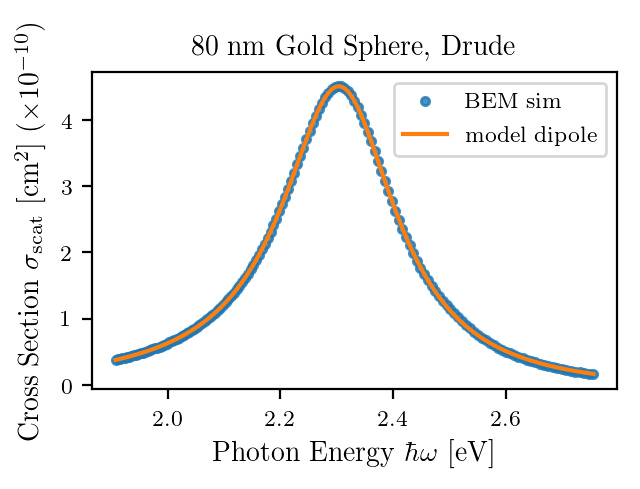

In [18]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

eneis = 1240/sphere_spec['enei'][0, :]
spec = sphere_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_TMatExp_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    eneis, 
    *result['x'],
    model_cross_section=cp.sigma_scat_TMatExp_sphere
    )
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result, label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'80 nm Gold Sphere, Drude')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

array([9.82335326e+00, 9.06705560e+00, 3.34860149e-02, 4.12504947e+01])

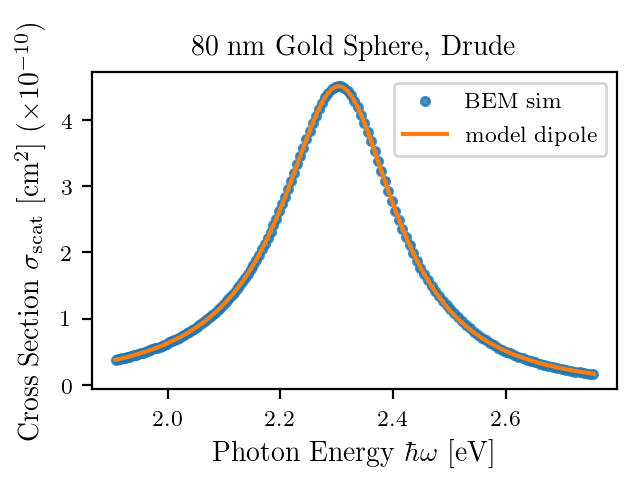

In [6]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

eneis = 1240/sphere_spec['enei'][0, :]
spec = sphere_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_Mie_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    eneis, 
    *result['x'],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result, label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'80 nm Gold Sphere, Drude')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

In [7]:
eneis[np.argmax(fit_result)]

2.3023052959501555

Checking BEM builtin Drude parameters

In [8]:
#   atomic units
_hartree = 27.2116              #  2 * Rydberg in eV
_tunit = 0.66 / _hartree  

In [9]:
_rs = 3                     #  electron gas parameter
_eps0 = 10              #  background dielectric constant
_gammad = _tunit / 10 

_density = 3 / ( 4 * np.pi * _rs**3 )
_wp = np.sqrt( 4 * np.pi * _density )

In [10]:
_wp*_hartree

9.070533333333335

In [11]:
_gammad * _hartree

0.066

In [4]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E',
    sphere_model='Mie')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


In [5]:
sim_inst.BEM_images.shape

(21, 10000)

In [13]:
sim_inst.calculate_polarization()
bem.save_sim_exp_inst(sim_inst, data_dir_name='sph_121219')

In [14]:
# sim_inst = bem.LoadedSimExp('sph_121119', 'sphere_80nmDrude')

In [24]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude',
    sphere_model='MLWA'
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
# fit_inst.plot_fit_results_as_quiver_map(sim_inst)   


 initial guess for molecule 0 location: (-0.05892467667244363,12.237097948663903)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.05892467667244363 
 ini_y,  12.237097948663903 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenching zone? True
Params modified, OG params: (-0.05892467667244363, 12.237097948663903, array([0.14925623]))
but now they are: (-0.24238179036906238, 50.336291639016004, array([0.14925623]))

 initial guess for molecule 1 location: (0.0005701615810727472,98.73369464299743)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.0005701615810727472 
 ini_y,  98.73369464299743 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenching zone? False

 initial guess for molecule 2 location: (0.00260158339165848,139.10883860242112)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.00260158339165848 
 ini_y,  139.10883860242112 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenc

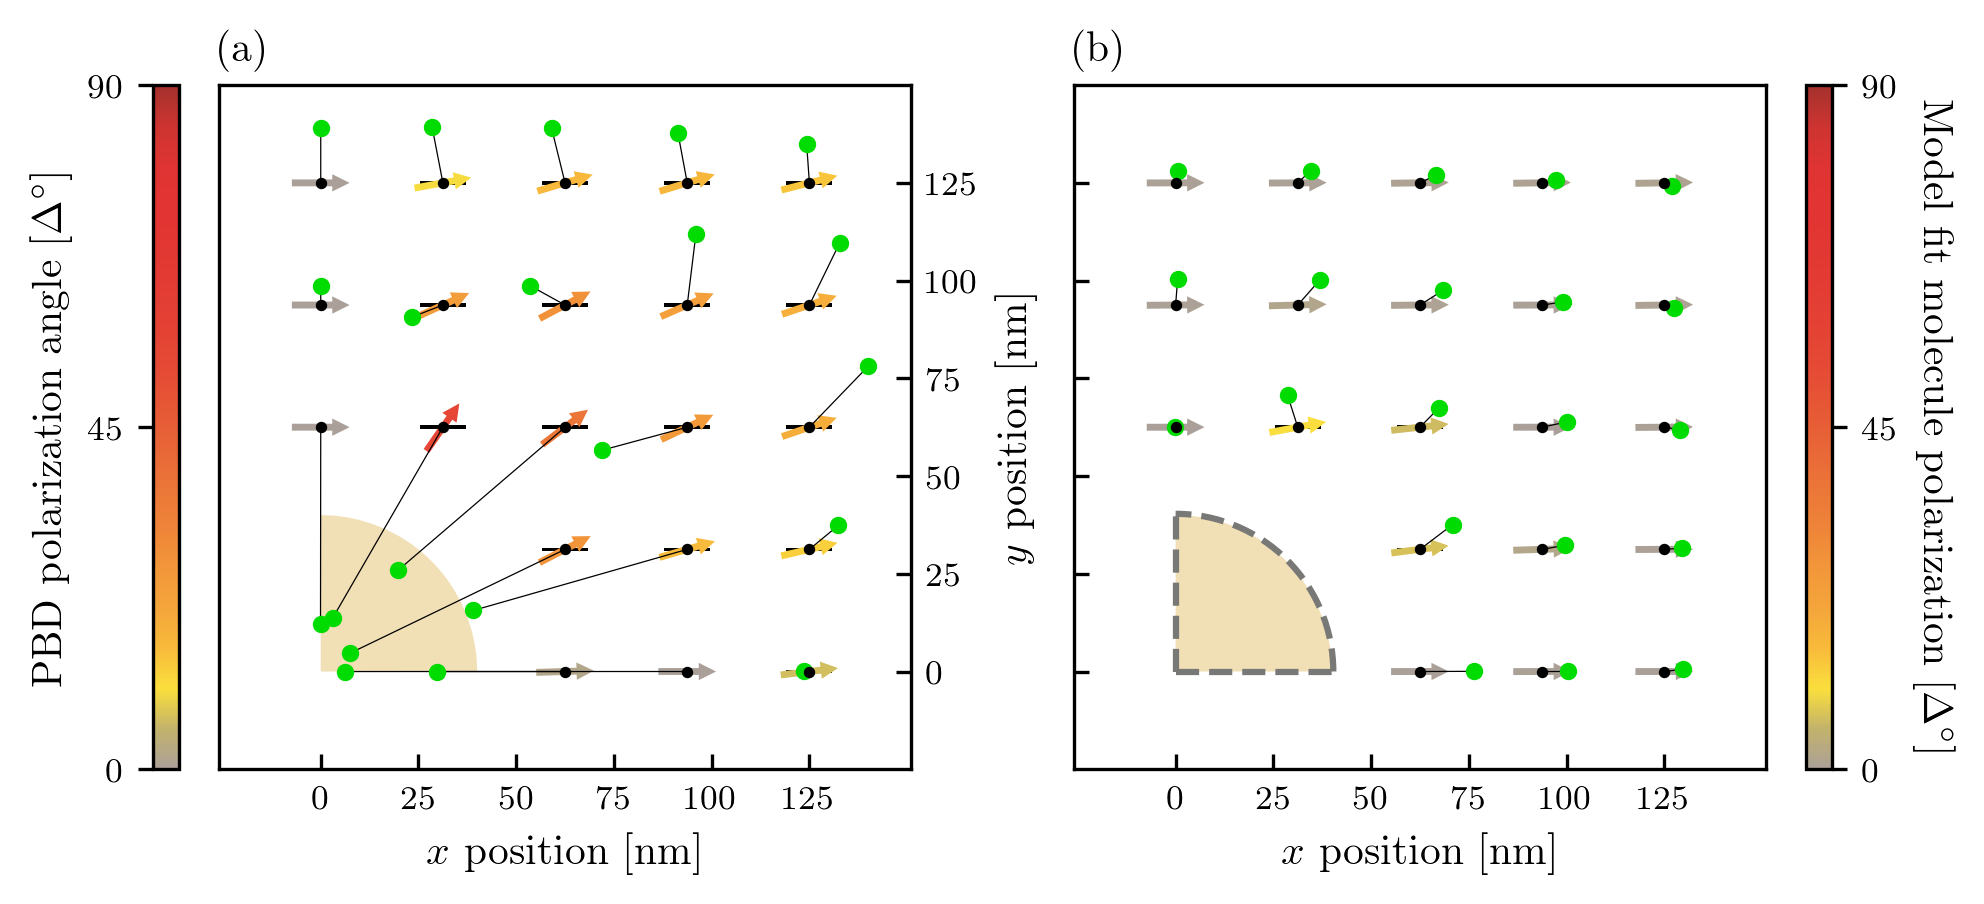

In [25]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

## Mie coefficients expansion

In [16]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_Mie',
    sphere_model='Mie',
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (-0.05956453895397893,12.22642284825891)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.05956453895397893 
 ini_y,  12.22642284825891 
 self.quel_a,  51.2504947 
 self.quel_c,  51.2504947 

In quenching zone? True
Params modified, OG params: (-0.05956453895397893, 12.22642284825891, array([1.25781421]))
but now they are: (-0.24967857724874126, 51.24988651307231, array([1.25781421]))

 initial guess for molecule 1 location: (-0.002218041915983311,98.73890736694932)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.002218041915983311 
 ini_y,  98.73890736694932 
 self.quel_a,  51.2504947 
 self.quel_c,  51.2504947 

In quenching zone? False

 initial guess for molecule 2 location: (-0.0004509271978574095,139.1403183498142)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.0004509271978574095 
 ini_y,  139.1403183498142 
 self.quel_a,  51.2504947 
 self.quel_c,  51.2504947 

In quenc

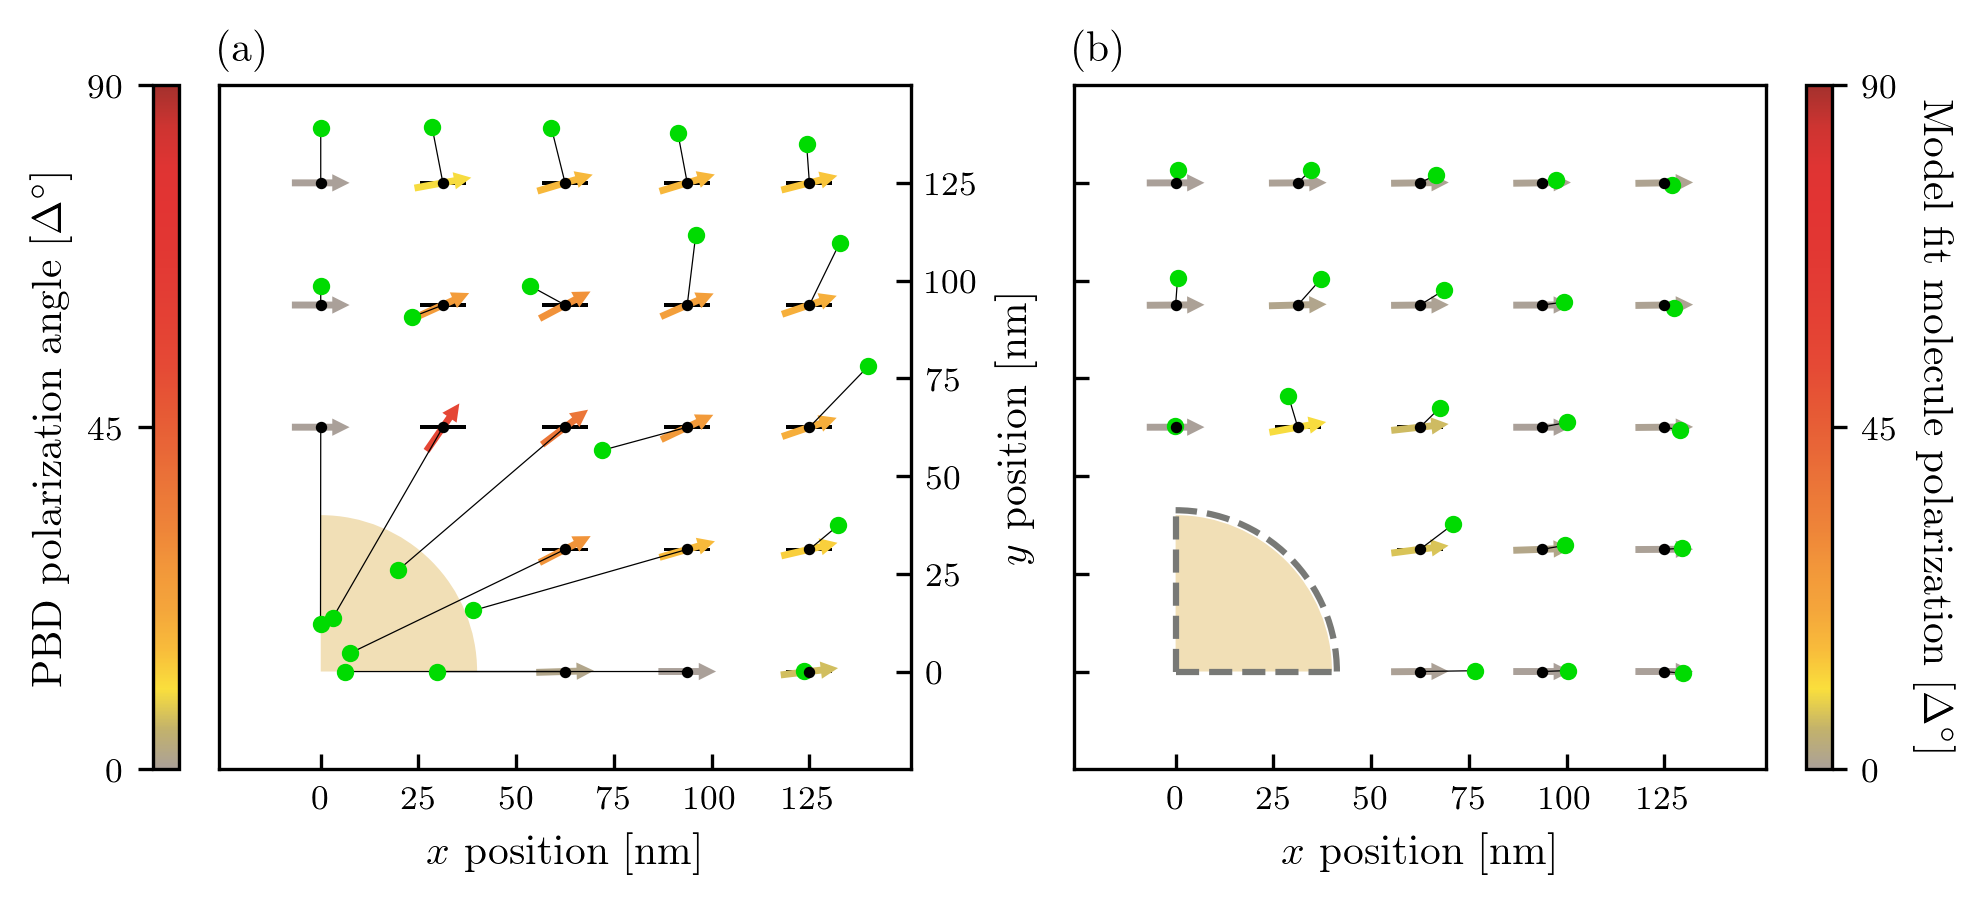

In [17]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

In [19]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_TMatExp',
    sphere_model='TMatExp',
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (-0.05956453895397893,12.22642284825891)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.05956453895397893 
 ini_y,  12.22642284825891 
 self.quel_a,  51.2570153 
 self.quel_c,  51.2570153 

In quenching zone? True
Params modified, OG params: (-0.05956453895397893, 12.22642284825891, array([0.90092071]))
but now they are: (-0.24971034385197777, 51.25640703569269, array([0.90092071]))

 initial guess for molecule 1 location: (-0.002218041915983311,98.73890736694932)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.002218041915983311 
 ini_y,  98.73890736694932 
 self.quel_a,  51.2570153 
 self.quel_c,  51.2570153 

In quenching zone? False

 initial guess for molecule 2 location: (-0.0004509271978574095,139.1403183498142)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.0004509271978574095 
 ini_y,  139.1403183498142 
 self.quel_a,  51.2570153 
 self.quel_c,  51.2570153 

In quenc

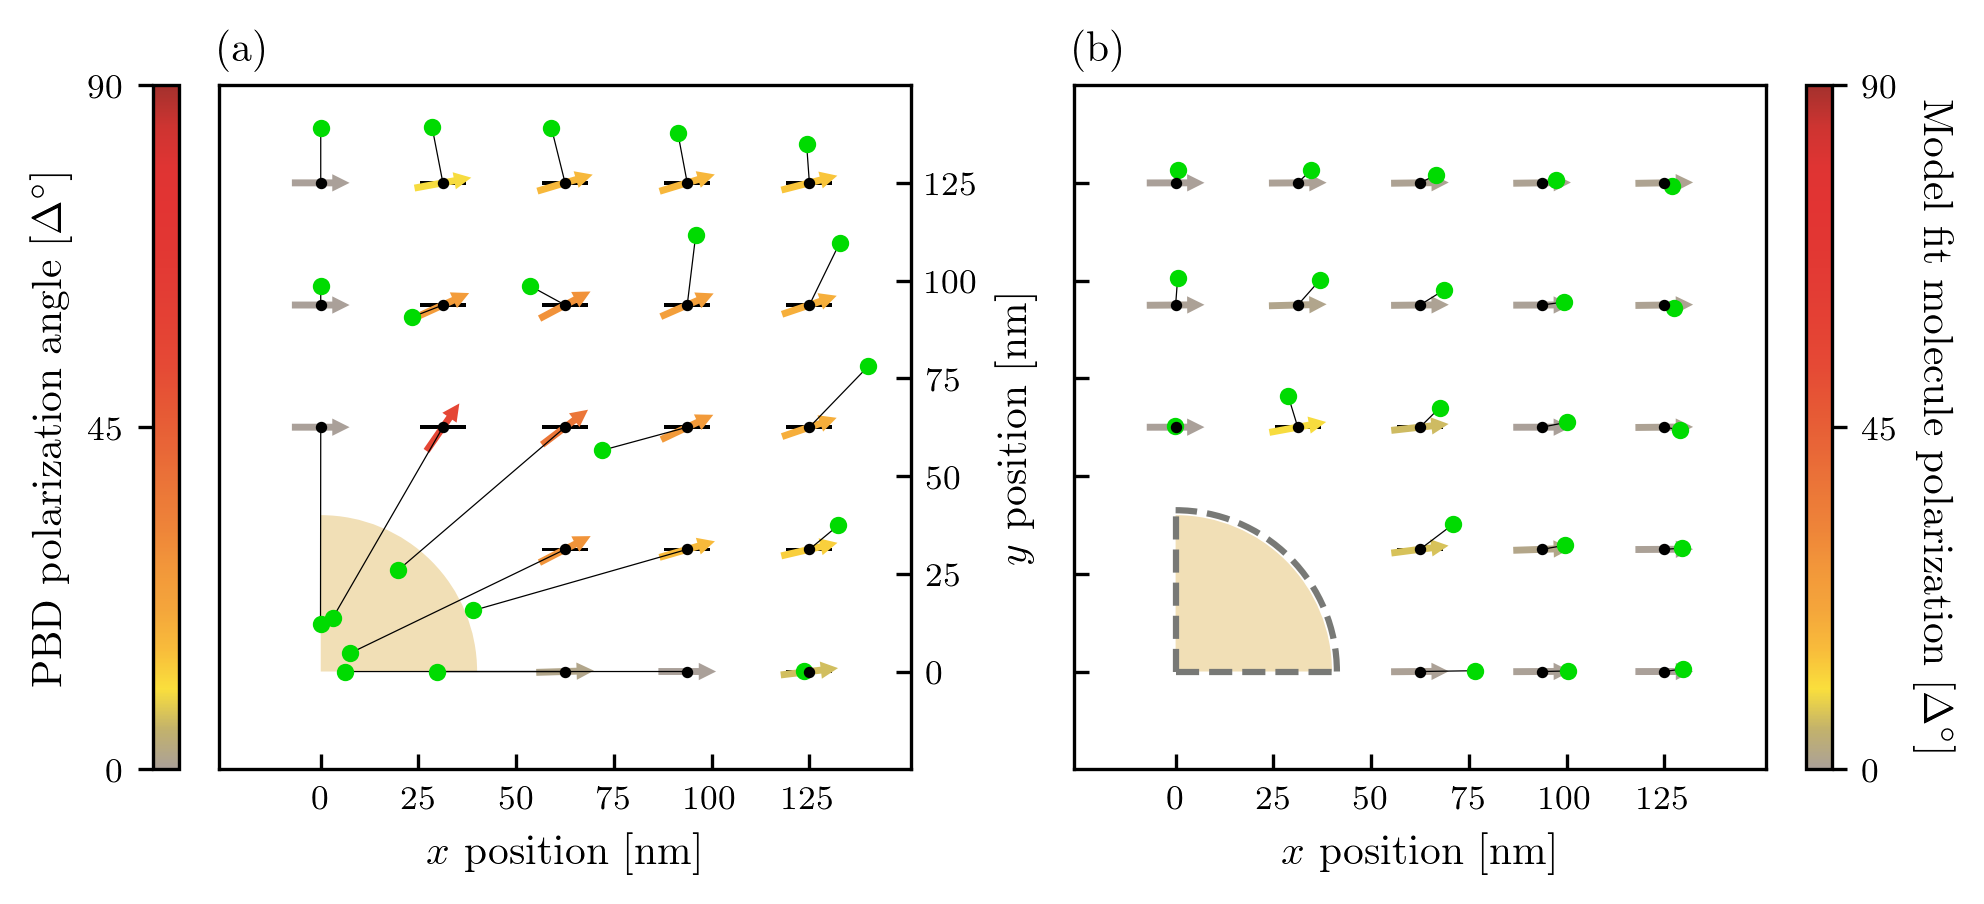

In [20]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

## Next thing to test is try converging the optics. 
I remember while working with Claire on teh widefield PT imaging that we could get noticably better convergence then what we had been using.. Not sure if that will make a difference here. 

In [21]:
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude_optics_conv',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E',
    sphere_model='Mie')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


In [22]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_optics_conv',
    sphere_model='MLWA'
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
# fit_inst.plot_fit_results_as_quiver_map(sim_inst)   


 initial guess for molecule 0 location: (-0.05892467667244363,12.237097948663903)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.05892467667244363 
 ini_y,  12.237097948663903 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenching zone? True
Params modified, OG params: (-0.05892467667244363, 12.237097948663903, array([1.26935231]))
but now they are: (-0.24238179036906238, 50.336291639016004, array([1.26935231]))

 initial guess for molecule 1 location: (0.0005701615810727472,98.73369464299743)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.0005701615810727472 
 ini_y,  98.73369464299743 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenching zone? False

 initial guess for molecule 2 location: (0.00260158339165848,139.10883860242112)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.00260158339165848 
 ini_y,  139.10883860242112 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenc

Calculating Gaussian centroid with BEM_images


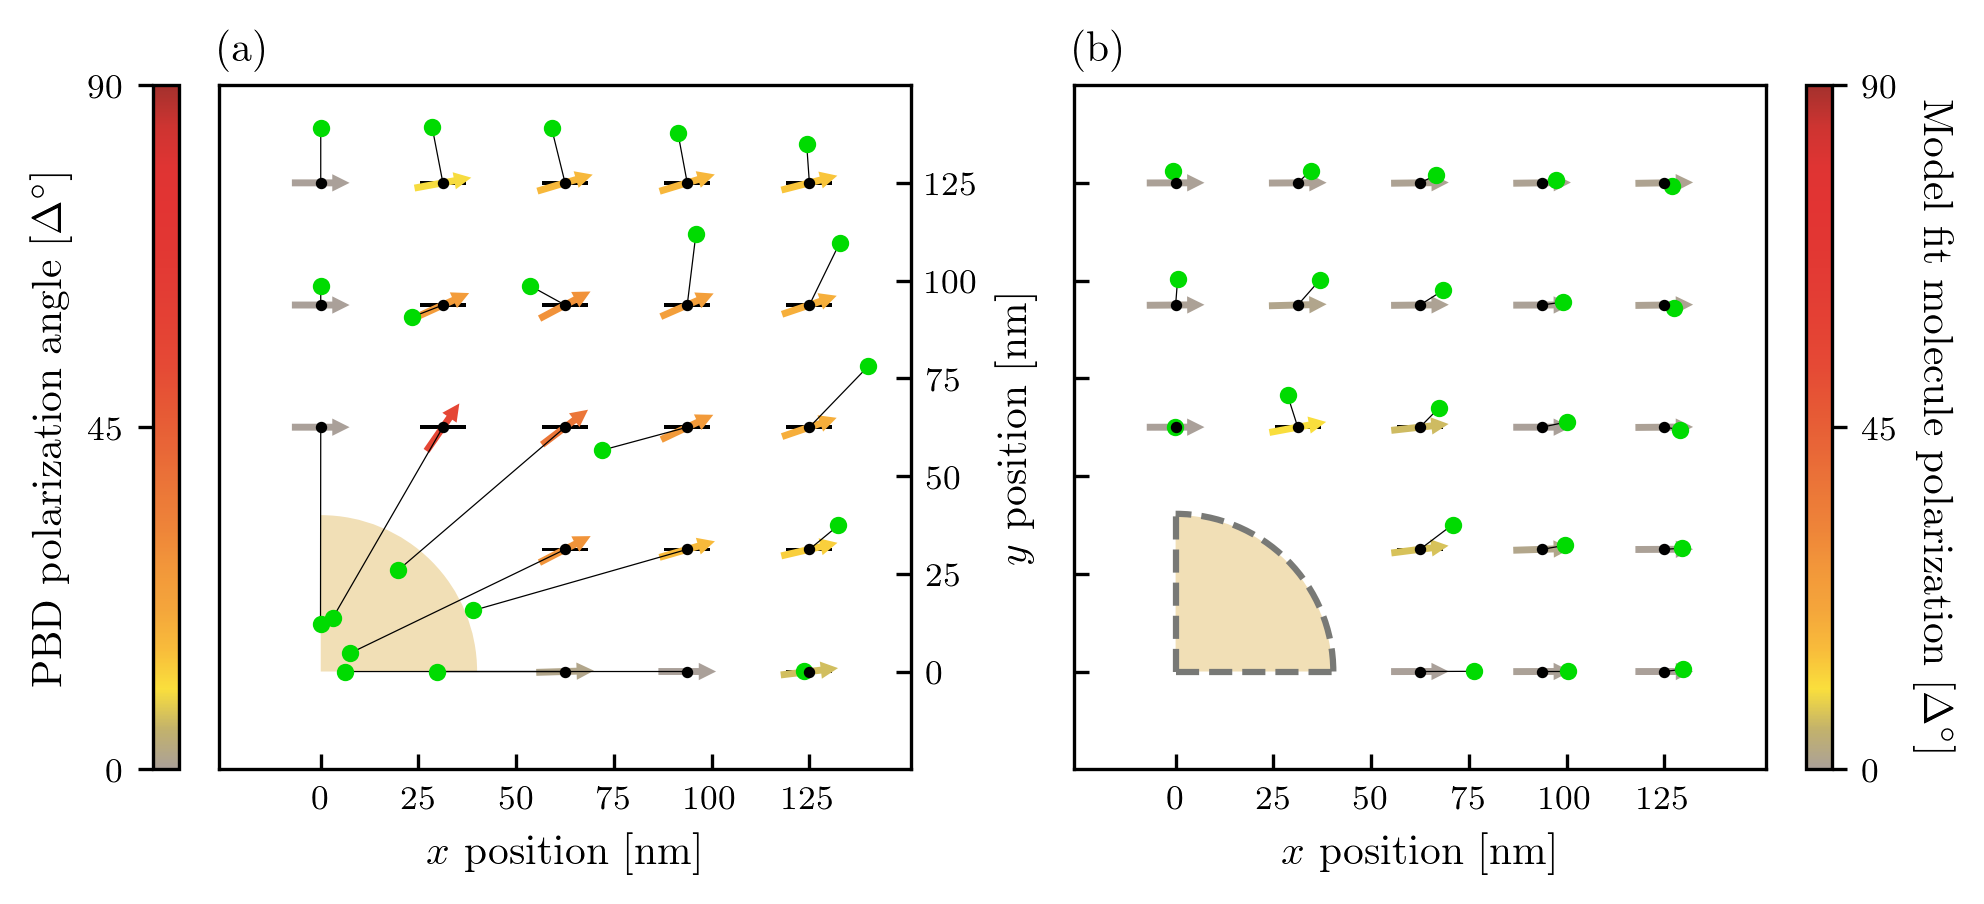

In [23]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

# Before 12/12/19

In [6]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude',
    sphere_style='TMatExp',
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (-0.006220893887620549,25.752255158636704)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.006220893887620549 
 ini_y,  25.752255158636704 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenching zone? True
Params modified, OG params: (-0.006220893887620549, 25.752255158636704, array([0.12945052]))
but now they are: (-0.0121597253595012, 50.336873731306106, array([0.12945052]))

 initial guess for molecule 1 location: (-0.008635377021831158,141.90427295401722)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.008635377021831158 
 ini_y,  141.90427295401722 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In quenching zone? False

 initial guess for molecule 2 location: (-0.007081994886150293,159.1181137825542)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.007081994886150293 
 ini_y,  159.1181137825542 
 self.quel_a,  50.3368752 
 self.quel_c,  50.3368752 

In

Calculating Gaussian centroid with BEM_images


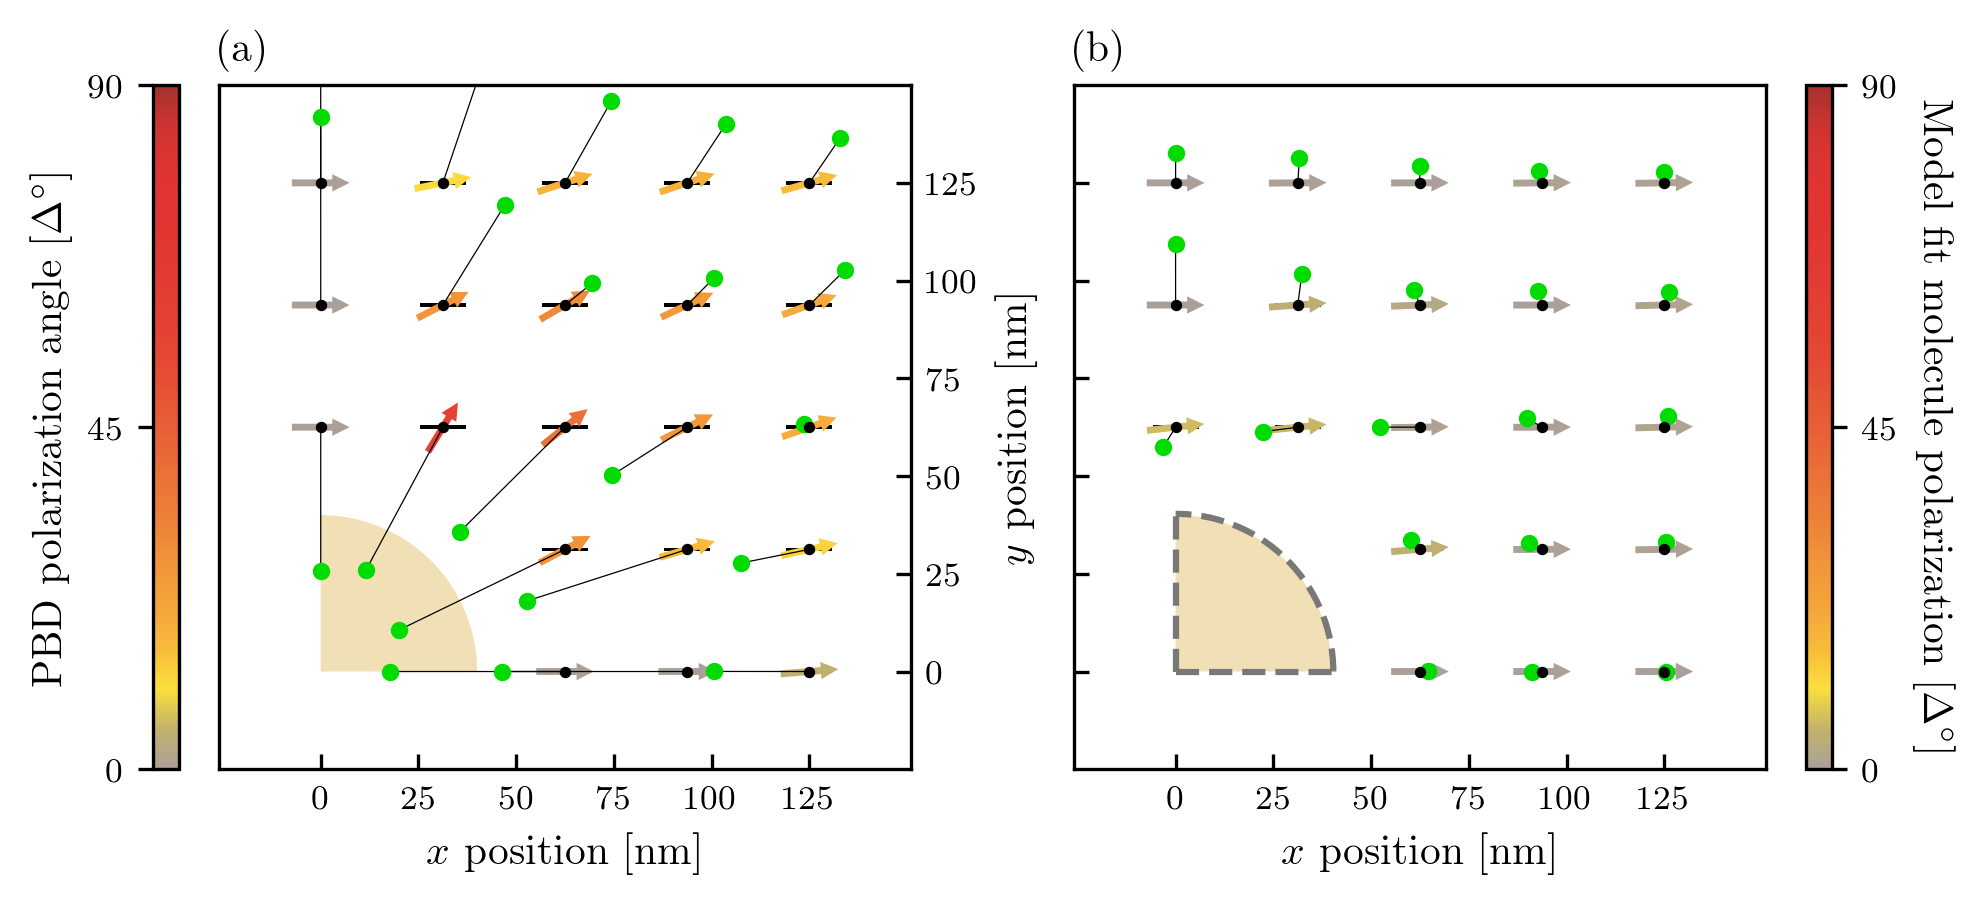

In [7]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

In [21]:
og_gau_cents = sim_inst.appar_cents

In [123]:
og_gau_cents

array([[-6.22089389e-03, -8.63537702e-03, -7.08199489e-03,
         1.16123924e+01,  4.71539930e+01,  4.11468454e+01,
         1.77480571e+01,  1.99144744e+01,  3.55691643e+01,
         6.95110190e+01,  7.42965021e+01,  4.64090774e+01,
         5.28007441e+01,  7.44292784e+01,  1.00538531e+02,
         1.03607364e+02,  1.00677361e+02,  1.07459584e+02,
         1.23641313e+02,  1.34208757e+02,  1.32841372e+02],
       [ 2.57522552e+01,  1.41904273e+02,  1.59118114e+02,
         2.60339271e+01,  1.19457787e+02,  1.54363633e+02,
        -7.82381116e-03,  1.05647901e+01,  3.57362110e+01,
         9.93872897e+01,  1.45886978e+02, -2.28427405e-03,
         1.80574413e+01,  5.01486941e+01,  1.00611760e+02,
         1.39989021e+02,  1.81483775e-02,  2.77313771e+01,
         6.33763522e+01,  1.02807181e+02,  1.36433965e+02]])

In [26]:
fit_inst.model_fit_results[:,2]

array([[-3.79446016e-01,  6.31216977e+01,  7.24790158e-03],
       [ 1.58114838e-02,  1.09134497e+02,  4.24982069e-04],
       [-2.75243763e-03,  1.34130023e+02,  5.26723937e-04],
       [ 2.93192884e+01,  6.62682416e+01,  7.88541558e-02],
       [ 3.29342190e+01,  1.01792303e+02,  5.41232827e-02],
       [ 3.24200002e+01,  1.32723982e+02,  4.67618907e-03],
       [ 7.07803978e+01,  8.44672663e-02,  4.41251938e-03],
       [ 6.67919367e+01,  3.50785899e+01,  9.27508516e-02],
       [ 6.07286290e+01,  6.51238565e+01,  5.66137521e-03],
       [ 6.29237656e+01,  9.87222261e+01,  2.70297403e-02],
       [ 6.34351084e+01,  1.30504289e+02,  2.76476680e-03],
       [ 9.66093292e+01,  1.81623336e-02,  1.07848640e-03],
       [ 9.57527456e+01,  3.31659123e+01,  8.46334790e-03],
       [ 9.41546488e+01,  6.58348011e+01,  1.93248140e-04],
       [ 9.50474161e+01,  9.84121141e+01,  9.28629166e-03],
       [ 9.39398866e+01,  1.29099740e+02,  1.63610087e-02],
       [ 1.29120191e+02,  1.13037440e-02

## Higher res simulation

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


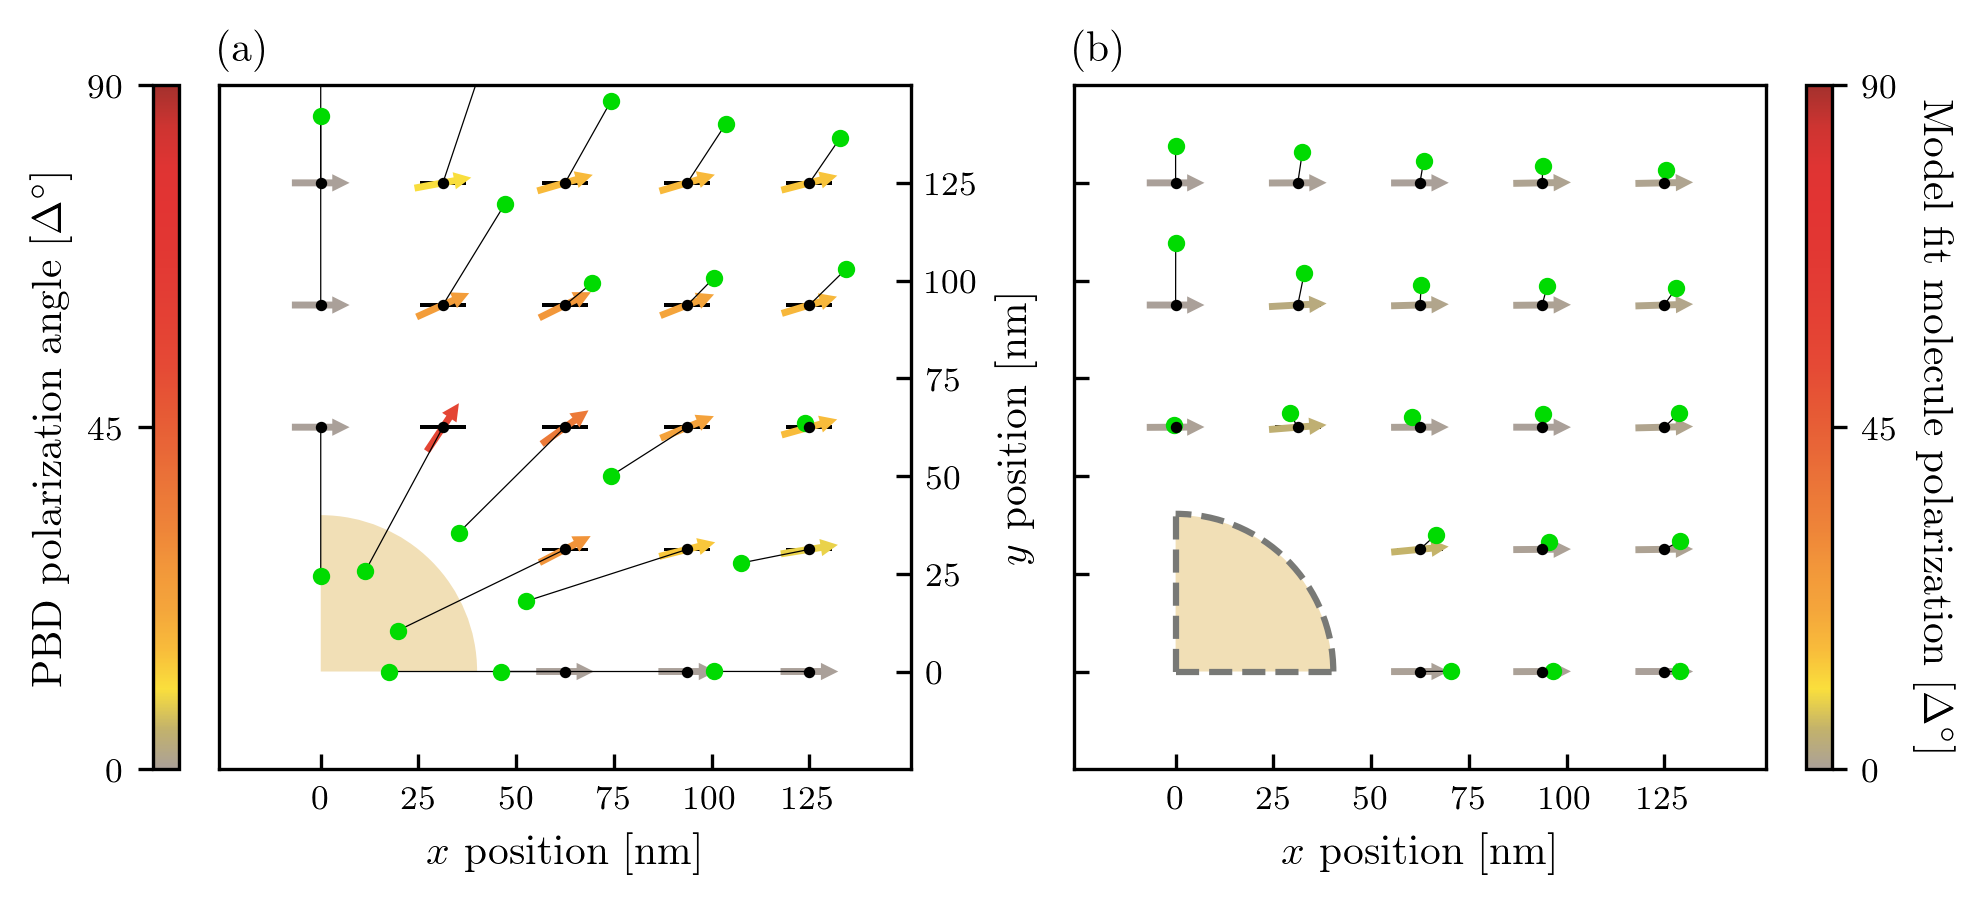

In [8]:

sim_inst_hr = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeHighDisc_NoSub_dipDrive_E')
sim_inst_hr.trial_images = sim_inst_hr.calculate_BEM_fields()

fit_inst_hr = fit.FitModelToData(
    sim_inst_hr.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit = fit_inst_hr.fit_model_to_image_data(
    check_ini=True)

fig5 = bem.fig5(sim_inst_hr, fit_inst_hr, draw_quadrant=True)

And even higher (1024)

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


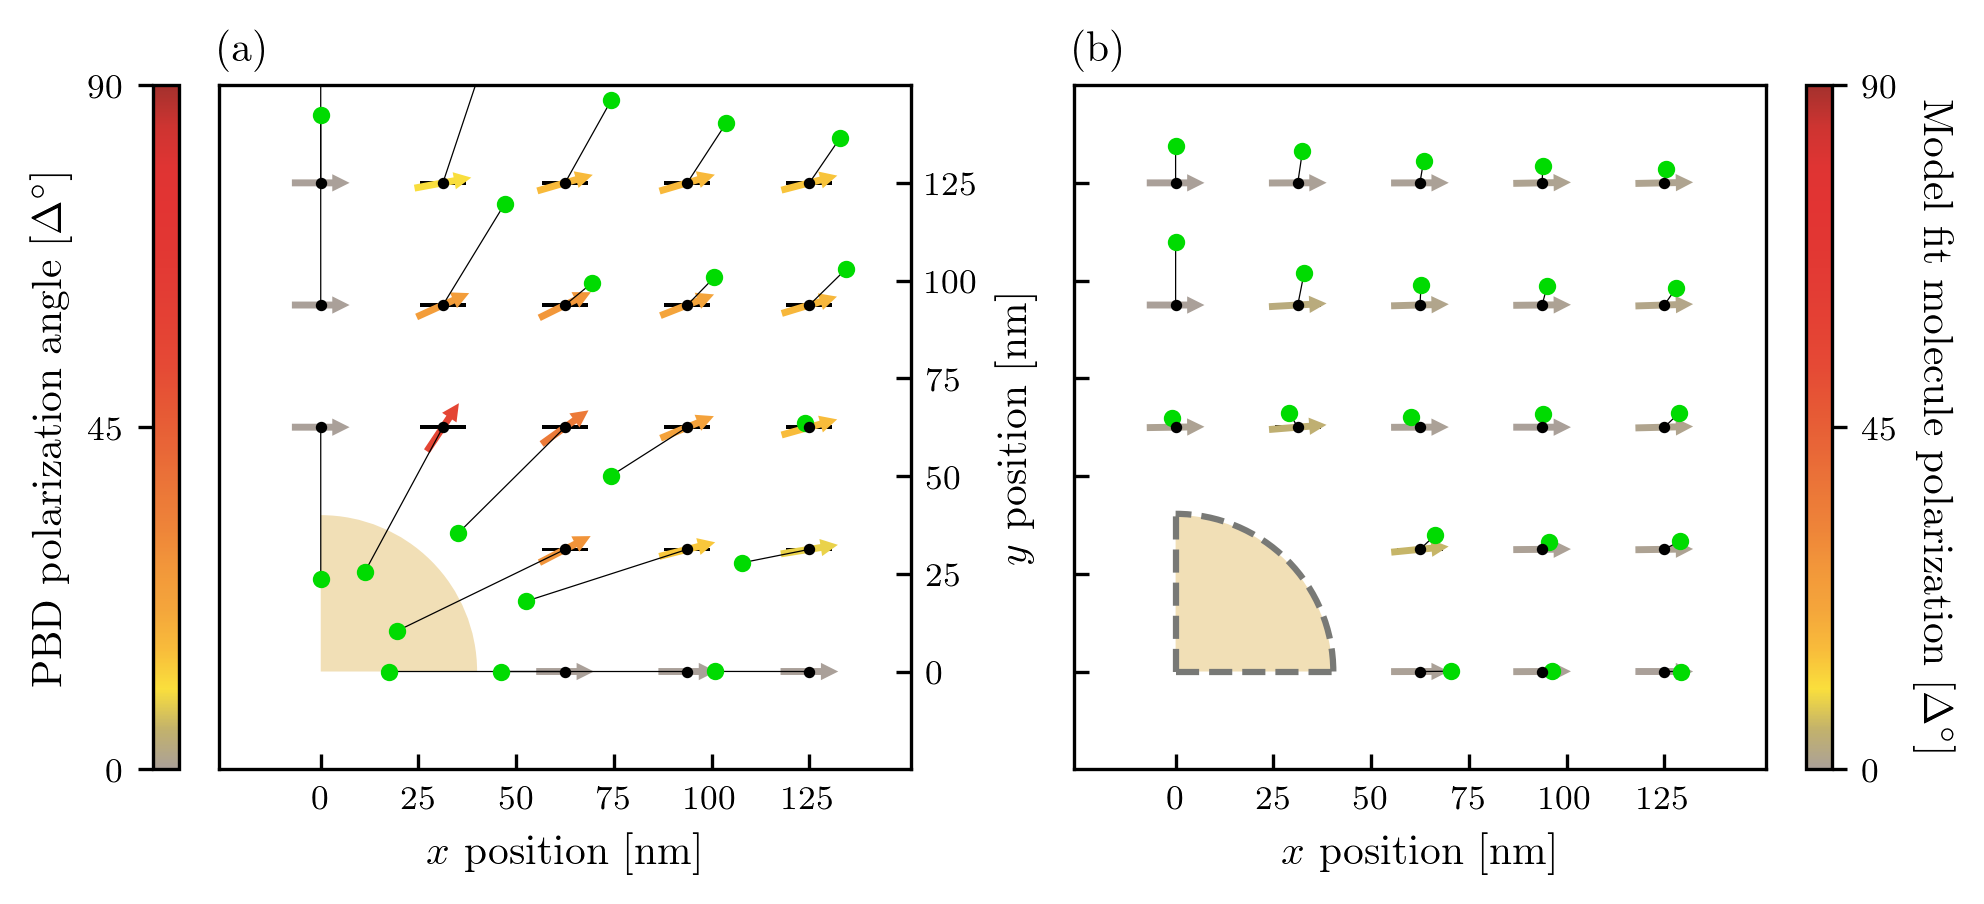

In [9]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_hd = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeHigherDisc_NoSub_dipDrive_E')
sim_inst_hd.trial_images = sim_inst_hd.calculate_BEM_fields()

fit_inst_hd = fit.FitModelToData(
    sim_inst_hd.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_hd = fit_inst_hd.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_hd.plot_fit_results_as_quiver_map(sim_inst_hd)   
fig5_HD = bem.fig5(sim_inst_hd, fit_inst_hd, draw_quadrant=True)

Drop down to 144 surface elements and see how that goes.

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


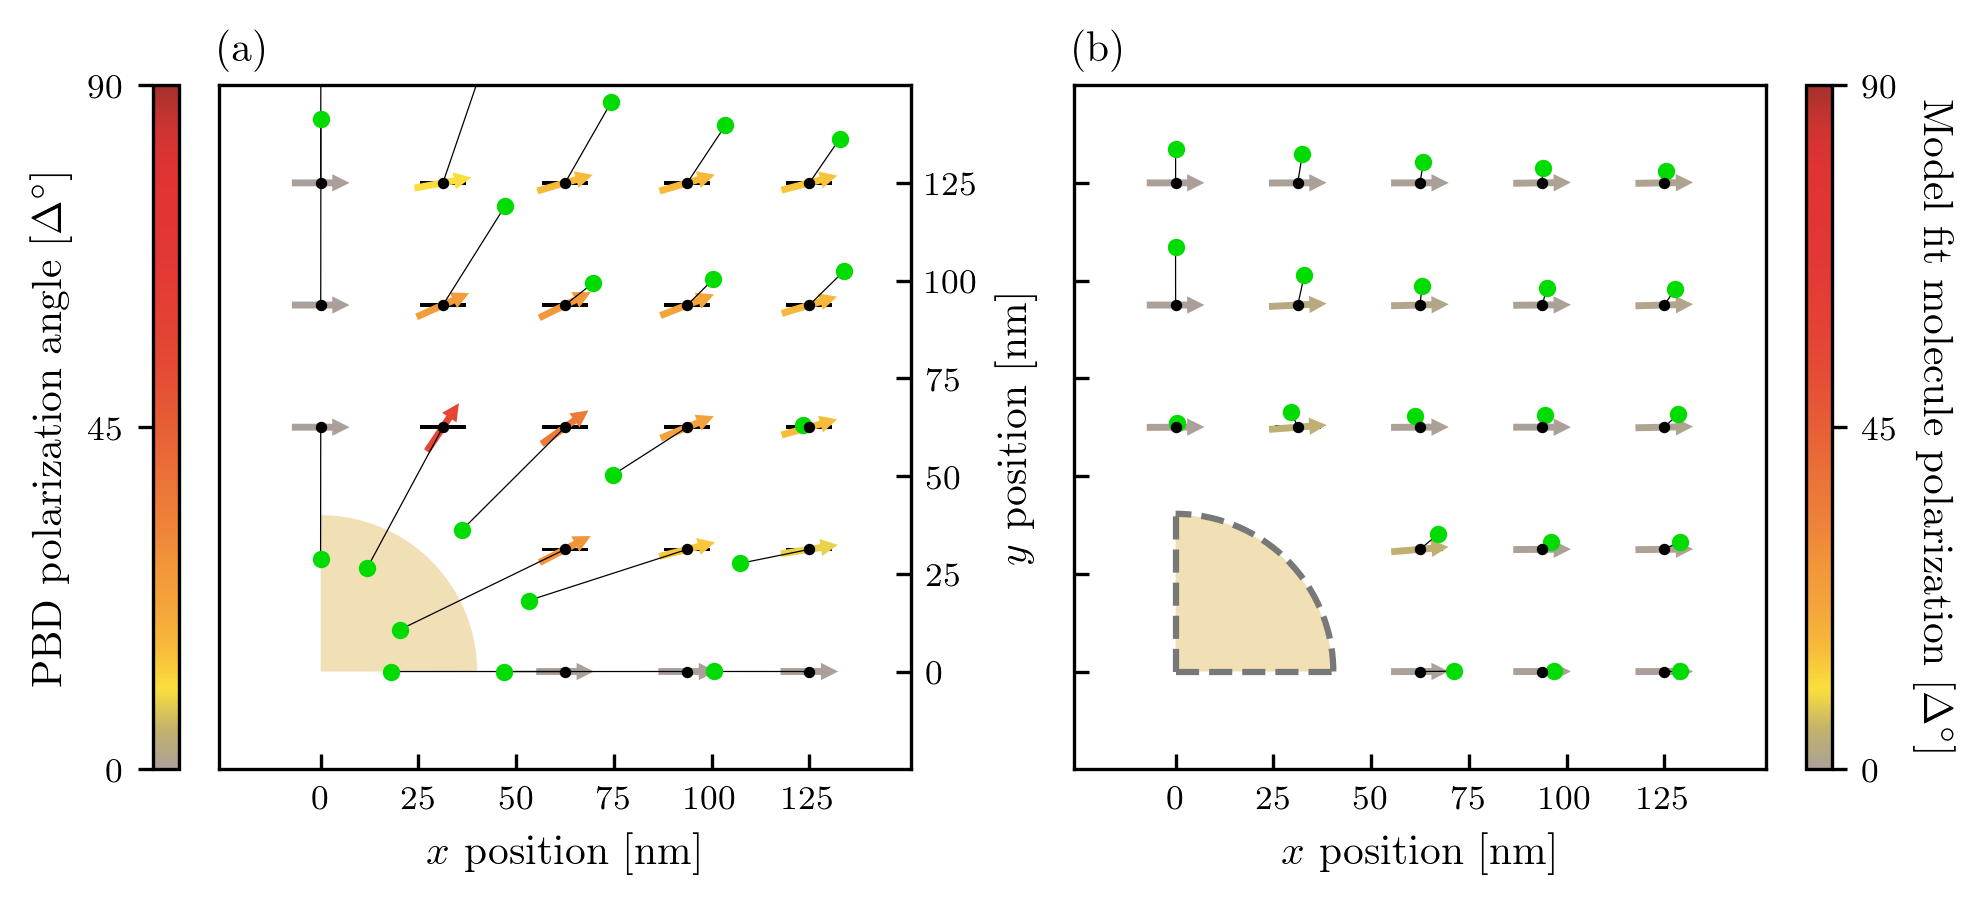

In [10]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_ld = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeLowDisc_NoSub_dipDrive_E')
sim_inst_ld.trial_images = sim_inst_ld.calculate_BEM_fields()

fit_inst_ld = fit.FitModelToData(
    sim_inst_ld.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_ld = fit_inst_ld.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_ld.plot_fit_results_as_quiver_map(sim_inst_ld)   
fig5_HD = bem.fig5(sim_inst_ld, fit_inst_ld, draw_quadrant=True)

And way down to 30 surface elements. Not convinced anything is changing. 

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


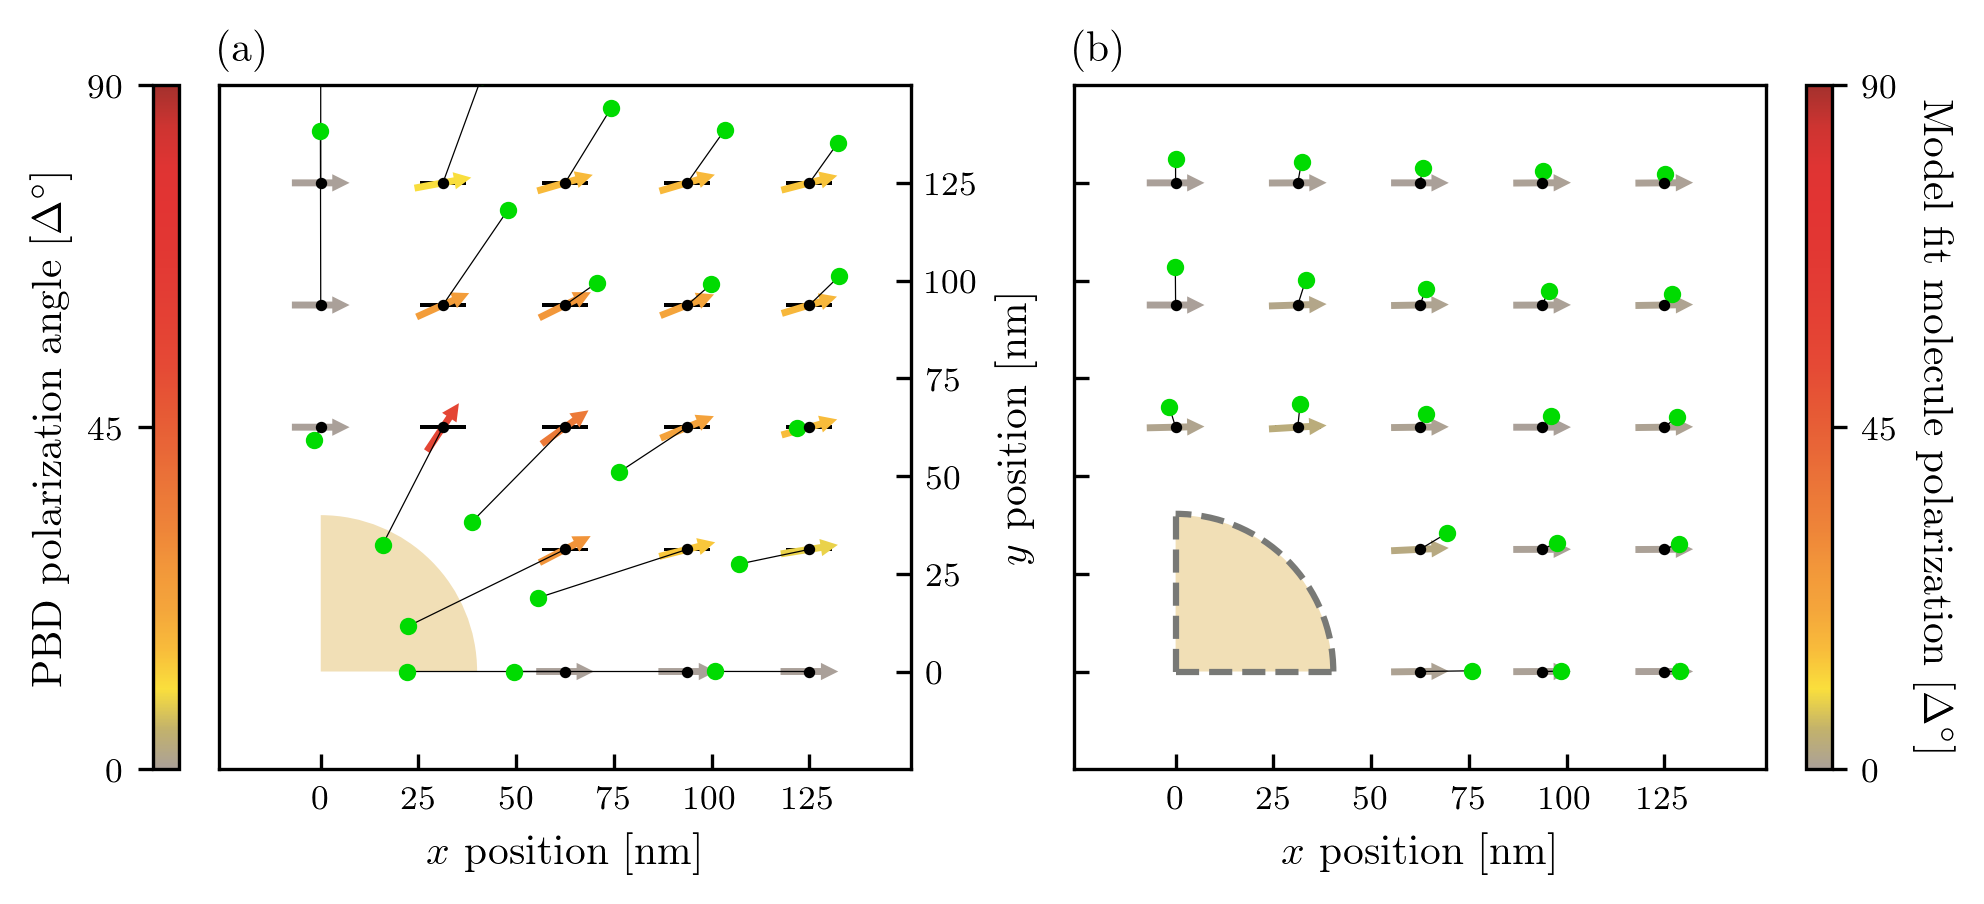

In [11]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_lld = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeLowLowDisc_NoSub_dipDrive_E')
sim_inst_lld.trial_images = sim_inst_lld.calculate_BEM_fields()

fit_inst_lld = fit.FitModelToData(
    sim_inst_lld.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_lld = fit_inst_lld.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_lld.plot_fit_results_as_quiver_map(sim_inst_lld)   
fig5_HD = bem.fig5(sim_inst_lld, fit_inst_lld, draw_quadrant=True)

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


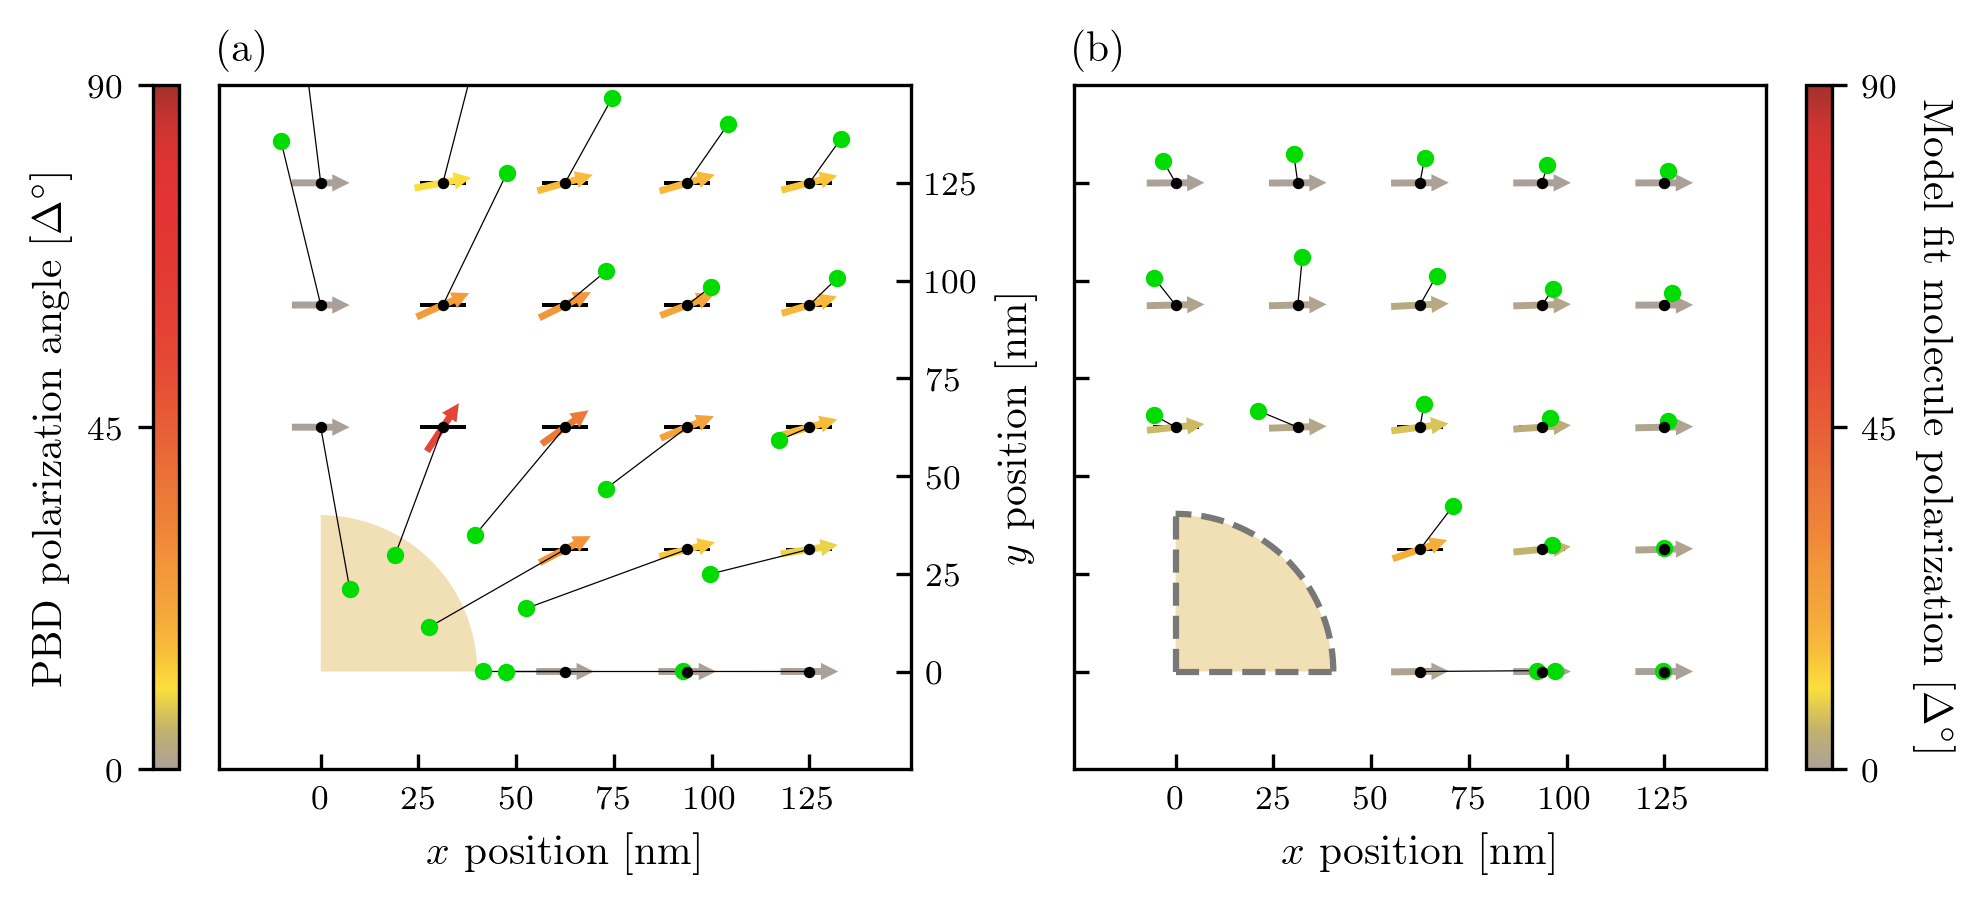

In [12]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_sh = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeTestShift_NoSub_dipDrive_E')
sim_inst_sh.trial_images = sim_inst_sh.calculate_BEM_fields()

fit_inst_sh = fit.FitModelToData(
    sim_inst_sh.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_sh = fit_inst_sh.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_sh.plot_fit_results_as_quiver_map(sim_inst_sh)   
fig5_HD = bem.fig5(sim_inst_sh, fit_inst_sh, draw_quadrant=True)

### Changing height of molecule

In [17]:
sph_sub_locations = locations - np.array([[0, 0, 40]])
sph_sub_locations


array([[  0.  ,   0.  , -40.  ],
       [  0.  ,  31.25, -40.  ],
       [  0.  ,  62.5 , -40.  ],
       [  0.  ,  93.75, -40.  ],
       [  0.  , 125.  , -40.  ],
       [ 31.25,   0.  , -40.  ],
       [ 31.25,  31.25, -40.  ],
       [ 31.25,  62.5 , -40.  ],
       [ 31.25,  93.75, -40.  ],
       [ 31.25, 125.  , -40.  ],
       [ 62.5 ,   0.  , -40.  ],
       [ 62.5 ,  31.25, -40.  ],
       [ 62.5 ,  62.5 , -40.  ],
       [ 62.5 ,  93.75, -40.  ],
       [ 62.5 , 125.  , -40.  ],
       [ 93.75,   0.  , -40.  ],
       [ 93.75,  31.25, -40.  ],
       [ 93.75,  62.5 , -40.  ],
       [ 93.75,  93.75, -40.  ],
       [ 93.75, 125.  , -40.  ],
       [125.  ,   0.  , -40.  ],
       [125.  ,  31.25, -40.  ],
       [125.  ,  62.5 , -40.  ],
       [125.  ,  93.75, -40.  ],
       [125.  , 125.  , -40.  ]])

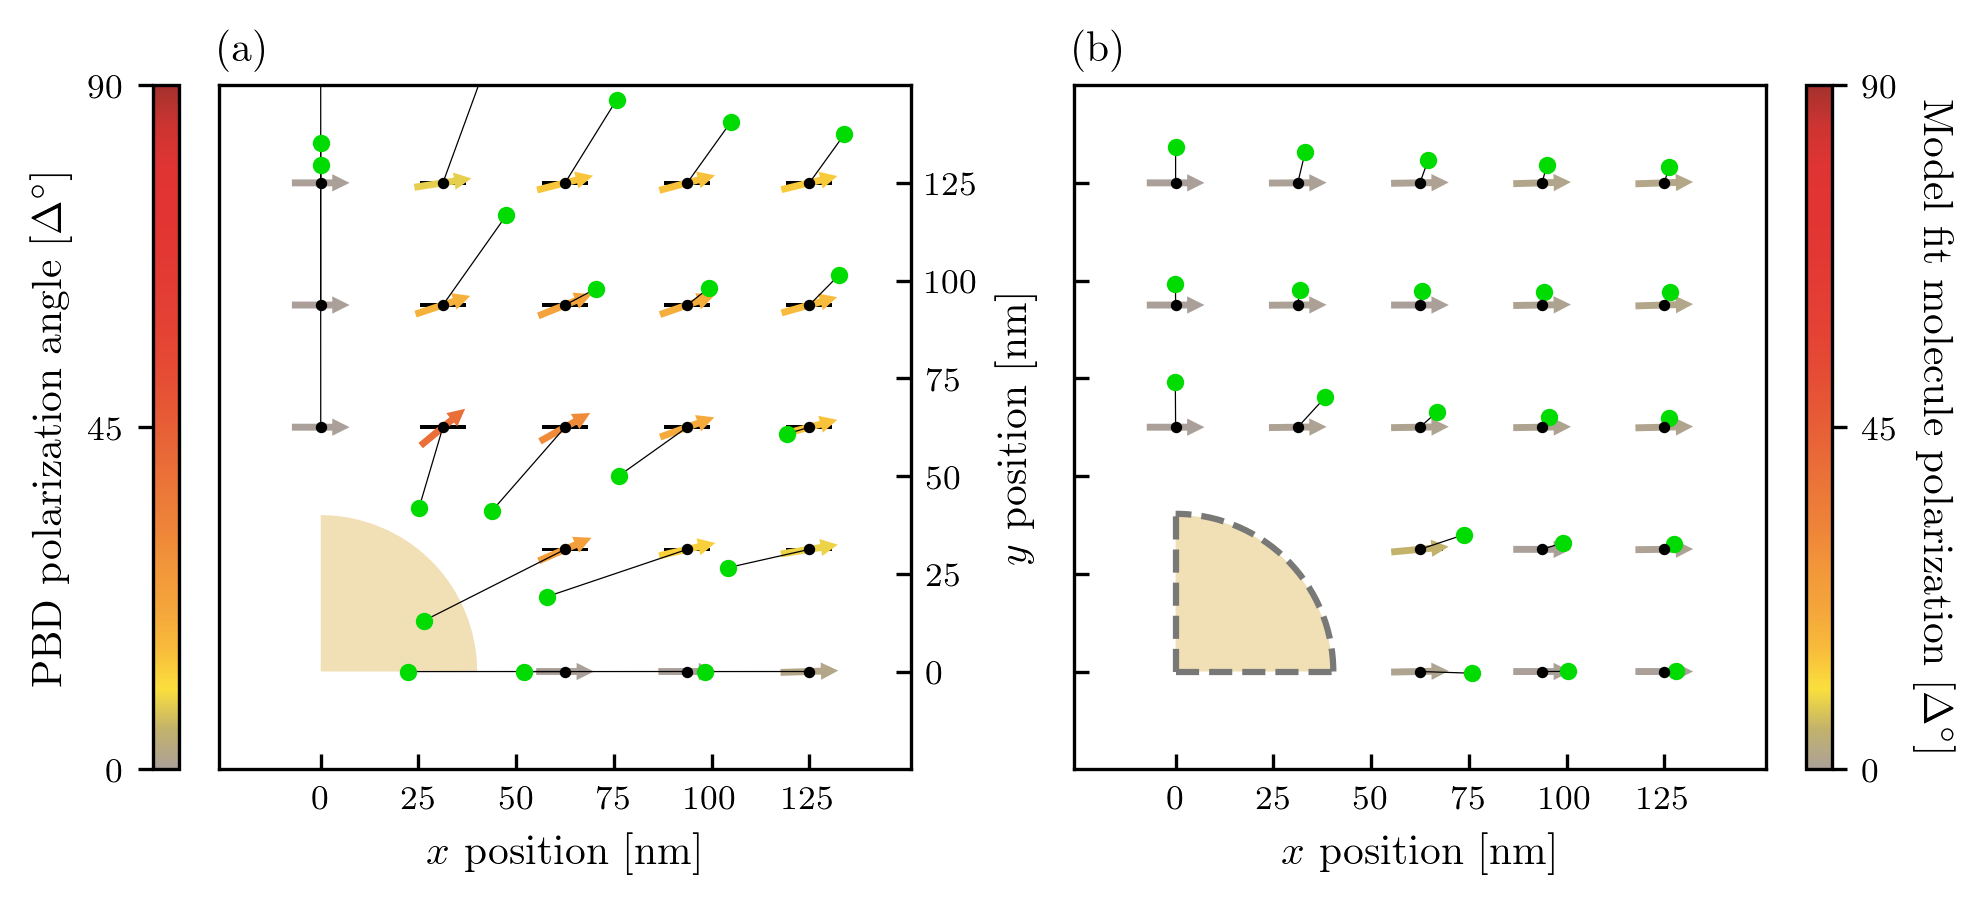

In [19]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_ms = bem.SimulatedExperiment(
    sph_sub_locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst_ms.trial_images = sim_inst_ms.calculate_BEM_fields()

fit_inst_ms = fit.FitModelToData(
    sim_inst_ms.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_ms = fit_inst_ms.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_ms.plot_fit_results_as_quiver_map(sim_inst_ms)   
fig5_ms = bem.fig5(sim_inst_ms, fit_inst_ms, draw_quadrant=True)

In [121]:
def connectpoints( cen_x, cen_y, mol_x, mol_y, p, ax=None, zorder=1, ls='k-'):
    x1, x2 = mol_x[p], cen_x[p]
    y1, y2 = mol_y[p], cen_y[p]
    if ax is None:
        plt.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)
    else:
        ax.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)

def scatter_prevCents_wLine(
    self,
    ax,
    x_mol_loc,
    y_mol_loc,
    est_locs,
    ):
    
    if est_locs == 'gauss':
        x_plot, y_plot = og_gau_cents

    elif est_locs == 'model':
        x_plot, y_plot = fit_inst.model_fit_results[:,:2].T
    
    for i in np.arange(x_plot.shape[0]):
        connectpoints(
            cen_x=x_plot,
            cen_y=y_plot,
            mol_x=x_mol_loc,
            mol_y=y_mol_loc,
            p=i,
            ax=ax,
            zorder=1,
            ls='k--'
            )
    localization_handle = ax.scatter(
        x_plot,
        y_plot,
        s=10,
        alpha=.5,
#         c=['C2'],
        zorder=2,
        facecolors='none', edgecolors='C4' 
        )
    return ax

In [118]:
# def loc_map_legend(ax, loc_label='fit localization'):
#         legend_elements = [
#             mpl.lines.Line2D(
#                 [0], [0],
#                 marker='o',
#                 color='w',
#                 label=loc_label,
#                 markerfacecolor=fit.PlottableDipoles.a_shade_of_green,
#                 markersize=10
#                 ),
#             mpl.lines.Line2D(
#                 [0], [0],
#                 marker='o',
#                 color='w',
#                 label='molecule location',
#                 markerfacecolor='black',
#                 markersize=8
#                 ),
#             ]

#         ax.legend(
#             handles=legend_elements,
#             loc='upper left',
#             bbox_to_anchor=(-.20,1.11),
#     #         ncol=2, mode="expand",
#             fontsize=8,
#             framealpha=1,
#     #         loc=1
#             )

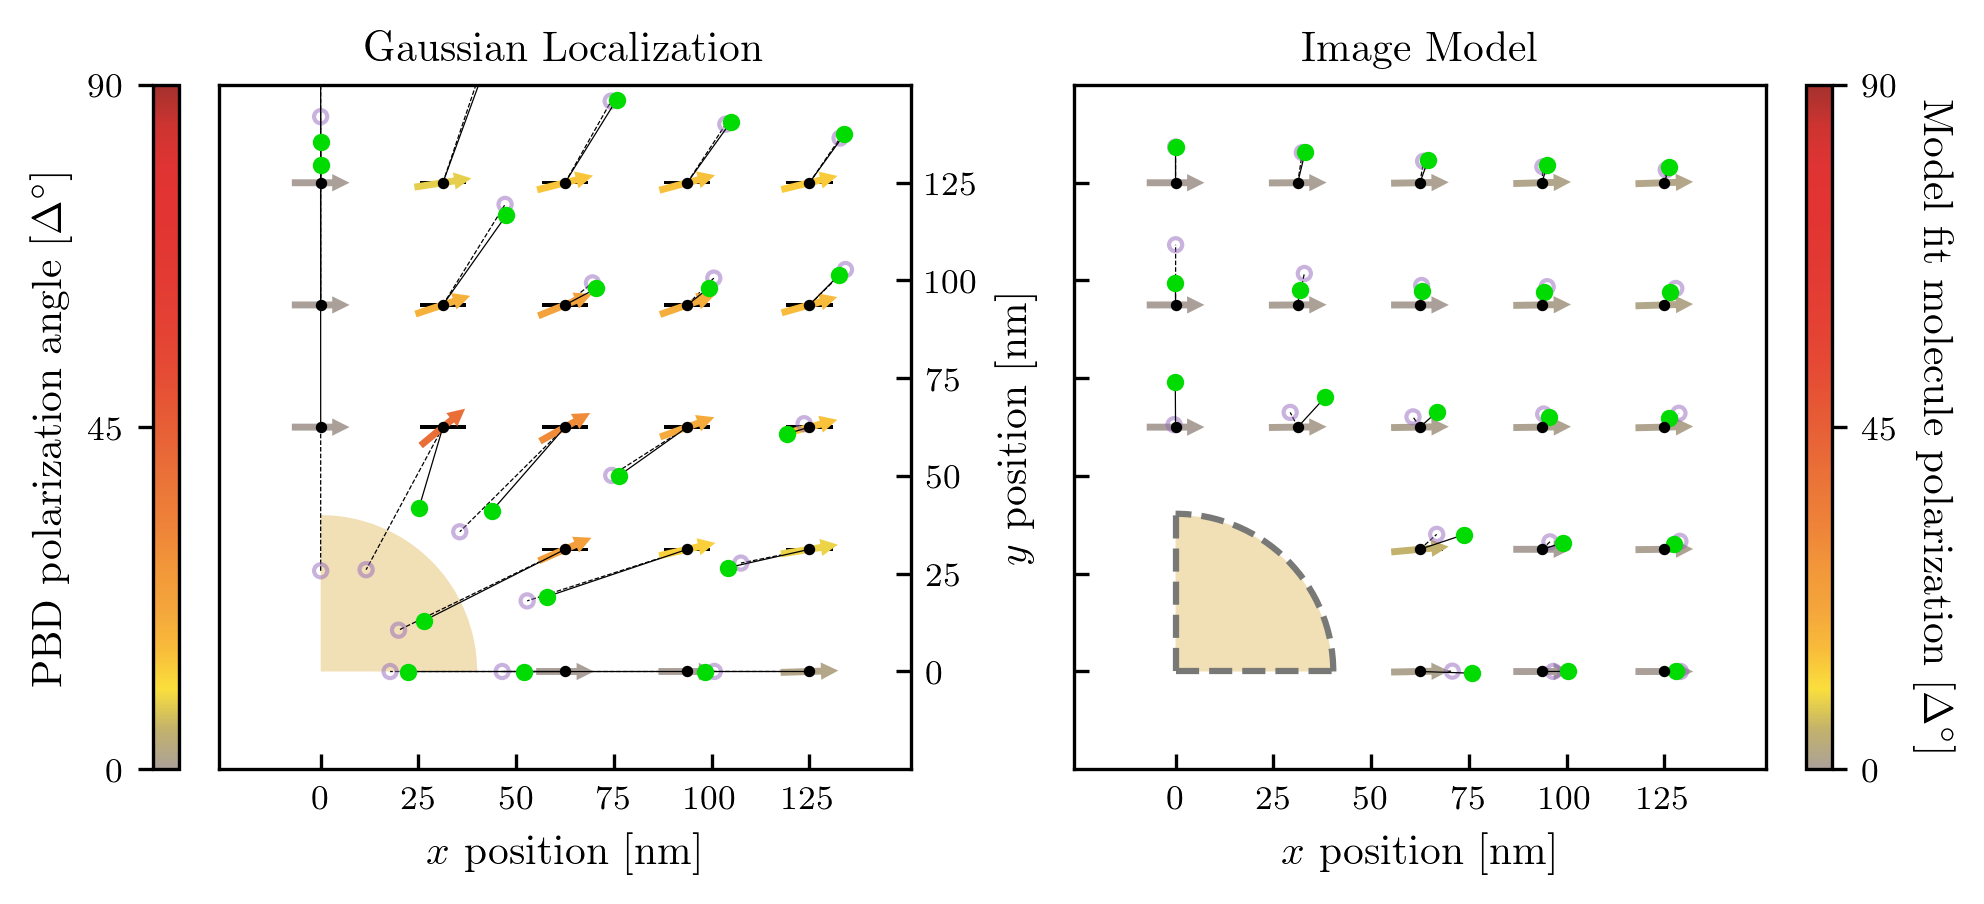

In [122]:
axs, fig5_ms = bem.fig5(
    sim_inst_ms, 
    fit_inst_ms, 
    draw_quadrant=True, 
    show_ax_labels=True,
#     show_legend=True
    )

scatter_prevCents_wLine(
    fit_inst_ms,
    axs[1],
    sim_inst_ms.mol_locations[:,0],
    sim_inst_ms.mol_locations[:,1],
    est_locs='gauss'
    )

scatter_prevCents_wLine(
    fit_inst_ms,
    axs[2],
    sim_inst_ms.mol_locations[:,0],
    sim_inst_ms.mol_locations[:,1],
    est_locs='model'
    )

# loc_map_legend(axs[2], loc_label='fit localization')

## lower NA and shift mol down. 

starting Matlab...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields

 initial guess for molecule 0 location: (-0.04227499668112695,129

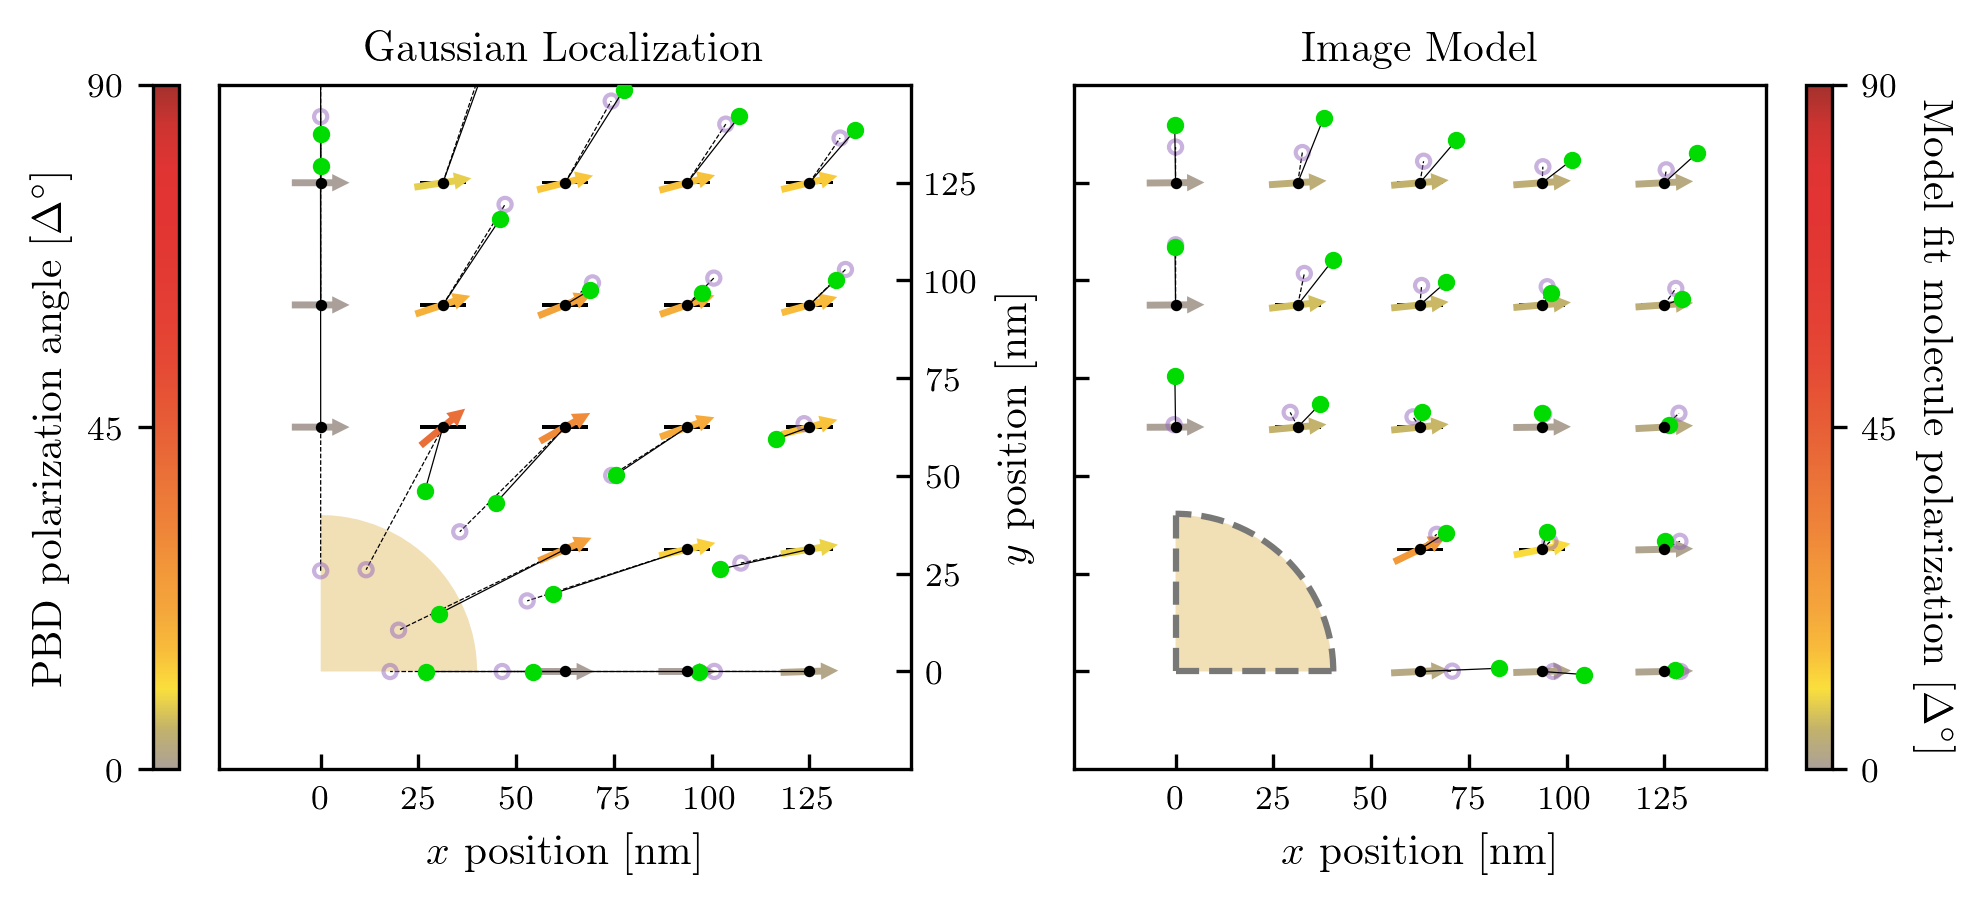

In [124]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_naoof = bem.SimulatedExperiment(
    sph_sub_locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude_NApt92',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst_naoof.trial_images = sim_inst_naoof.calculate_BEM_fields()

fit_inst_naoof = fit.FitModelToData(
    sim_inst_naoof.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_NApt92'
    )
the_fit_naoof = fit_inst_naoof.fit_model_to_image_data(
    check_ini=True)

##Build Plot
axs, fig5_naoof = bem.fig5(
    sim_inst_naoof, 
    fit_inst_naoof, 
    draw_quadrant=True, 
    show_ax_labels=True,
#     show_legend=True
    )

scatter_prevCents_wLine(
    fit_inst_naoof,
    axs[1],
    sim_inst_naoof.mol_locations[:,0],
    sim_inst_naoof.mol_locations[:,1],
    est_locs='gauss'
    )

scatter_prevCents_wLine(
    fit_inst_naoof,
    axs[2],
    sim_inst_naoof.mol_locations[:,0],
    sim_inst_naoof.mol_locations[:,1],
    est_locs='model'
    )

# loc_map_legend(axs[2], loc_label='fit localization')